In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import ThreeBalls2DFreeFallDataset

import torch
from torch.utils.data import DataLoader

import reservoirpy as rpy
from reservoirpy.nodes import Input, Reservoir, Ridge, ReLU, ESN
from reservoirpy.observables import mse

from itertools import product

rpy.verbosity(0)
rpy.set_seed(42)

In [2]:
def calculate_test_loss(model, dataloader, dataset, visualize_first_10_trajectories=True):
    test_loss = (np.sum([mse(model.run(X.squeeze().numpy()), y.squeeze().numpy())*len(y) for X, y in dataloader]) / len(dataset)) ** 0.5
    print('Test loss: ', test_loss)

    if visualize_first_10_trajectories:
        _, axs1 = plt.subplots(2, 5, figsize=(20,10))
        _, axs2 = plt.subplots(2, 5, figsize=(20,10))

        plt.title('Y-coordinates over time')
        for X, y in dataloader:
            pred = model.run(X.squeeze().numpy())

            for count in range(10):
                gr = np.insert(y.squeeze().numpy()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][-3:-1])
                pr = np.insert(pred.squeeze()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][-3:-1])

                axs1[int(count >= 5)][count % 5].plot(gr[1::2], label=f'Ground truth')
                axs1[int(count >= 5)][count % 5].plot(pr[1::2], label='Predicted')
                axs1[int(count >= 5)][count % 5].legend()

                axs2[int(count >= 5)][count % 5].plot(gr[0::2], gr[1::2], label=f'Ground truth')
                axs2[int(count >= 5)][count % 5].plot(pr[0::2], pr[1::2], label='Predicted')
                axs2[int(count >= 5)][count % 5].legend()

            break

        plt.show()
    return test_loss

In [3]:
batch_size = 32

train_data, test_data = ThreeBalls2DFreeFallDataset.train_test_split('../data/raw/three-balls-2d-free-fall-full', test_frac=0.2)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  10562
train_test_split response: test fraction rounded to 0.19998485250123074 (10562 simulations)


In [4]:
# Parameters for cross-validation hyperparameter turning

n_units = [50, 70, 100, 150, 300, 500]
lrs = [0.5, 0.7, 0.9]
srs = [0.95, 0.99, 1.5, 5]
ridges = [1e-4, 1e-3, 1e-2]

In [5]:
# dictionary to store the results

import pickle

results = {}

try:
    with open('results_dict_2d_three_balls.pkl', 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [6]:
if results == {}:

    # Performing cross-validation hypterparameter turning

    results['simple_esn'] = []

    for units, lr, sr, ridge in product(n_units, lrs, srs, ridges):
        print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

        rpy.set_seed(42)

        reservoir1 = Reservoir(units=units, lr=lr, sr=sr, input_bias=False)
        readout1 = Ridge(output_dim=48, ridge=ridge) >> ReLU()

        model1 = reservoir1 >> readout1

        for X, y in train_dataloader:
            model1.fit(X.squeeze().numpy(), y.squeeze().numpy())

        test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=False)

        results['simple_esn'].append(
            {
                'units': units,
                'lr': lr,
                'sr': sr,
                'ridge': ridge,
                'test_loss': test_loss
            }
        )

        print()

        with open('results_dict_2d_three_balls.pkl', 'wb') as f:
            pickle.dump(results, f)

Best result:  {'units': 70, 'lr': 0.9, 'sr': 0.95, 'ridge': 0.01, 'test_loss': 0.08388044118497237}
Test loss:  0.02586385986991868


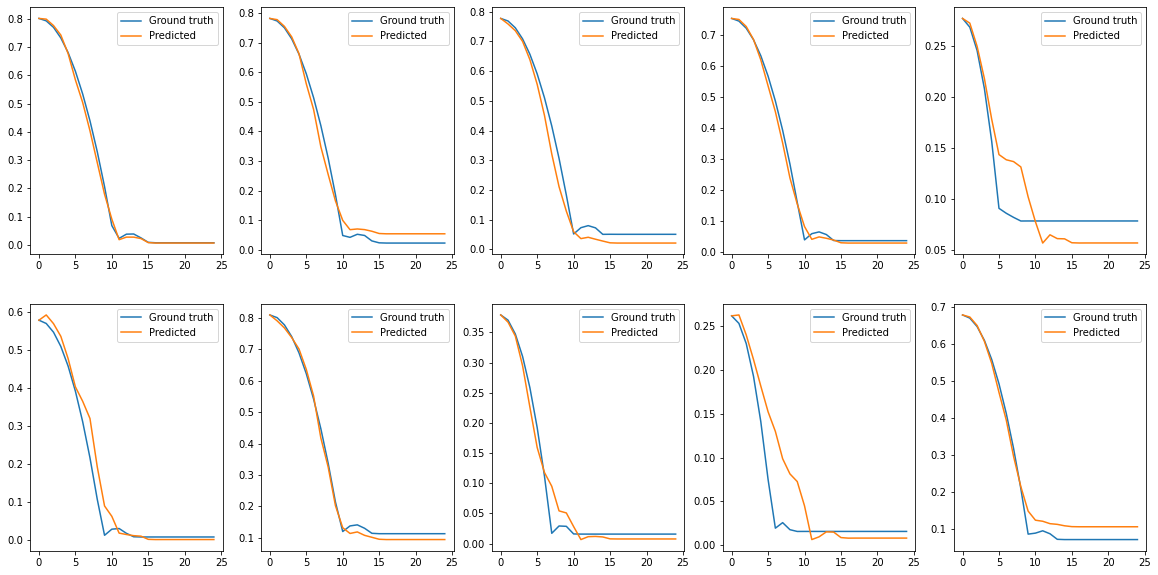

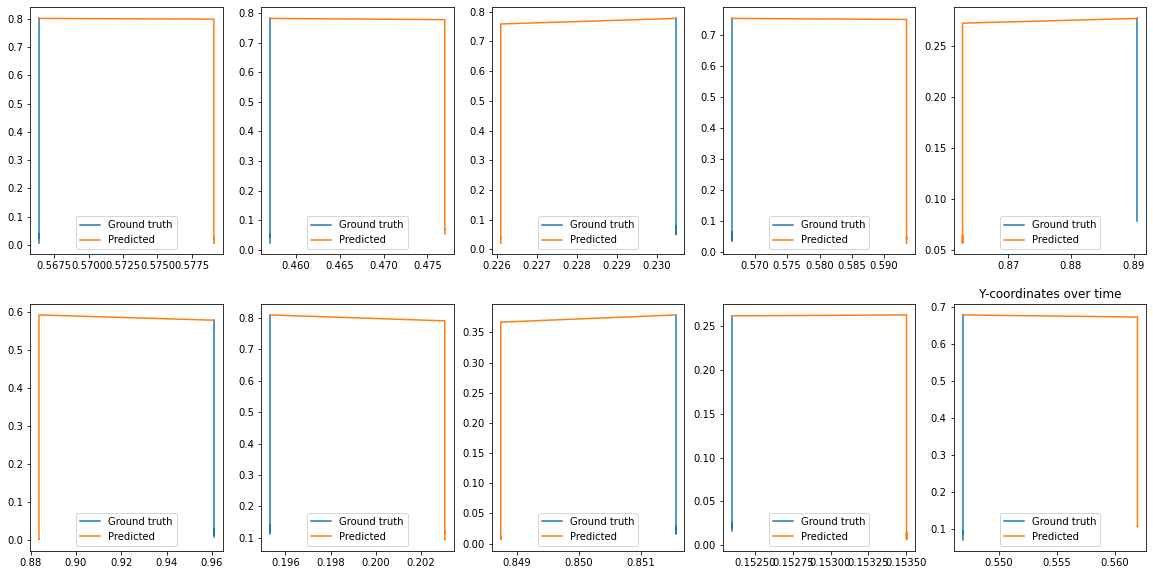

In [7]:
best_result = min(results['simple_esn'], key=lambda x: x['test_loss'])

print('Best result: ', best_result)

rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=48, ridge=best_result['ridge']) >> ReLU()

model1 = reservoir1 >> readout1

for X, y in train_dataloader:
    model1.fit(X.squeeze().numpy(), y.squeeze().numpy())


test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=True)